### Use of formants for instrument recognition

In this notebook the Linear Predictive Coding is used in order to extract the formants of a signal. Then, the first 2 formants (F1, F2) are considered as spectral features that describe sounds. In addition, an initial analysis of the potential of F1 and F2 to classifify sounds is carried out. Created by Davide Busacca,Jan. 2018

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import essentia.standard as ess
from scipy.signal import tf2zpk
from scipy import signal
import matplotlib.patches as mpatches

class AnalysisParams:
    def __init__(self,fs,LPCorder,nFreq,maxFreqToDisp=0):
        self.fs=fs
        self.LPCorder = LPCorder
        self.nFreq = nFreq
        self.maxFreqToDisp = maxFreqToDisp

def normalize(x):
    '''
    This function normalizes an array input in the interval [0,1]
    '''
    return (x-min(x))/(max(x)-min(x))
    
def getFormantFrequenciesWrapper(fileData, params):
    '''
    Wrapper that gives access to the getFormantFrequencies() function
    '''
    fs=params.fs
    LPCorder=params.LPCorder
    nFreq=params.nFreq
    maxFreqToDisp=params.maxFreqToDisp
    
    x=ess.MonoLoader(filename = os.path.join(fileData['path'], fileData['name']), sampleRate=fs)()
    
    ff, fm = getFormantFrequencies(x,fs,LPCorder,nFreq, maxFreqToDisp)
    fileData['formantFreq']=ff
    fileData['formantMagn']=fm
    
def getFormantFrequencies(x,fs,LPCorder,nFreq, maxFreqToDisp=0):
    '''
    This function return the most significative formants of a signal obtained 
    by the poles computed with Linear Predictive Coding
    
    INPUT:    
    x: input signal
    fs: sample rate
    LPCorder: number of LPC coefficient to be computed
    nFreq: number of pole frequency returned by the function
    maxFreqToDisp: highest frequency plotted in the spectrum,
                   if is 0 nothing is displayed
    
    OUTPUT:
    formantFreq: frequency values of the most significant poles computed
    formantMagn: magnitude values of the most significant poles computed
    '''
    
    #Creating Objects containing Essentia functions 
    Spectrum=ess.Spectrum()
    Envelope=ess.LowPass(sampleRate=1, cutoffFrequency=1.0/len(x)*30)
    LPC = ess.LPC(order=LPCorder, sampleRate=fs)

    #Computing LPC coefficients
    a, _= LPC(x)
    
    #Filter Design, let's find the pole (roots of the denominator))
    #a is the denominator, while b is the numerator
    b=1   
    z, p, k = tf2zpk(b, a)  

    #Polar representation of the poles
    freq=np.angle(p)/(2*np.pi)*fs
    magn=20*np.log10(np.abs(p)+np.finfo(float).eps)
    
    #Choose the most representative poles according to their closeness to unit circle (i.e. radius)
    nPoles=nFreq*2+1 #every complex pole has a conjugate and there is always one pole at frequency 0Hz
    sortedIndexes=np.argsort(magn)
    formantFreq=freq[sortedIndexes[-nPoles:]]
    formantMagn=magn[sortedIndexes[-nPoles:]]
    formantFreq=np.round(formantFreq[np.where(formantFreq>0)])
    formantMagn=magn[np.where(formantFreq>0)]
    #Sort by frequency
    sortedIndexesF=np.argsort(formantFreq)
    formantFreq=formantFreq[sortedIndexesF]
    formantMagn=formantMagn[sortedIndexesF]
    
    #Plotting
    if(maxFreqToDisp>0):
        fig = plt.figure(figsize=(9, 8), dpi= 80, facecolor='w', edgecolor='k')
        first = fig.add_subplot(211)
        t_axis=np.arange(len(x))/float(fs)
        first.plot(t_axis, x)
        first.axis((0,max(t_axis),-1,1))

        second = fig.add_subplot(212)

        #plot LPC filter response
        formantSpectrum_color='r'
        f_freqz, formantSpectrum = signal.freqz(b, a) #get filter response starting from numerator and denominator
        f_axis2=f_freqz/np.pi*fs/2 
        formantSpectrum = 20*np.log10(np.abs(formantSpectrum))
        formantSpectrum_n=normalize(formantSpectrum)
        second.plot(f_axis2, formantSpectrum_n,linewidth=2.0,   color=formantSpectrum_color, label='(Normalized)LPC Filter Response')    
        #add annotations of the formants detected
        for i in np.arange(len(formantFreq)):
            idx = (np.abs(f_axis2-formantFreq[i])).argmin()
            second.annotate("F"+str(i+1)+': '+str(int(formantFreq[i])), xy=(formantFreq[i],formantSpectrum_n[idx]), \
                            xytext=(formantFreq[i],formantSpectrum_n[idx]-0.40), \
                            arrowprops=dict(facecolor='black', shrink=0.10))
    
        #plot spectrum envelope
        mX_color='b'
        mX=20*np.log10(Envelope(Spectrum(x))/len(x)+np.finfo(float).eps)
        mX_n=normalize(mX)
        f_axis=np.arange(len(mX))/float(len(mX))*fs/2
        second.plot(f_axis, mX_n, color=mX_color, label='(Normalized)Spectrum Envelope')
        second.axis((0,maxFreqToDisp,0,1))

        #add legend
        second.legend(loc='best')
        plt.show()
    
    return formantFreq, formantMagn    

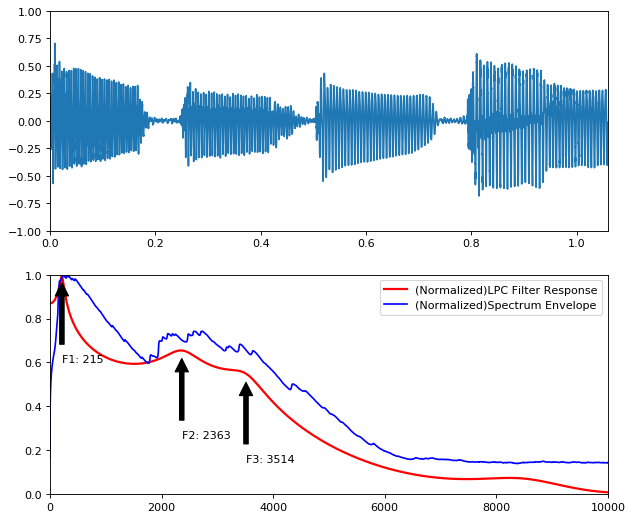

In [2]:
#Analysis (and plot) of a signal
fs=44100
LPCorder=20
nFreq=3
maxFreqToDisp=10000
file="data/guitar.wav"#https://freesound.org/people/hubertmichel/sounds/40403/
x = ess.MonoLoader(filename=file, sampleRate=fs)()
ff_g, fm_g = getFormantFrequencies(x,fs,LPCorder,nFreq,maxFreqToDisp)

In the first plot, the signal is plotted in time domain.

In the second plot, the envelope of the spectrum computed on the overall signal is plotted in blue, whereas the LPC filter response is plotted in red. In addition, the first 3 formants are highlighted. All the magnitude values are normalized in the range [0,1].

The choice of the LPC order affects the filter response.

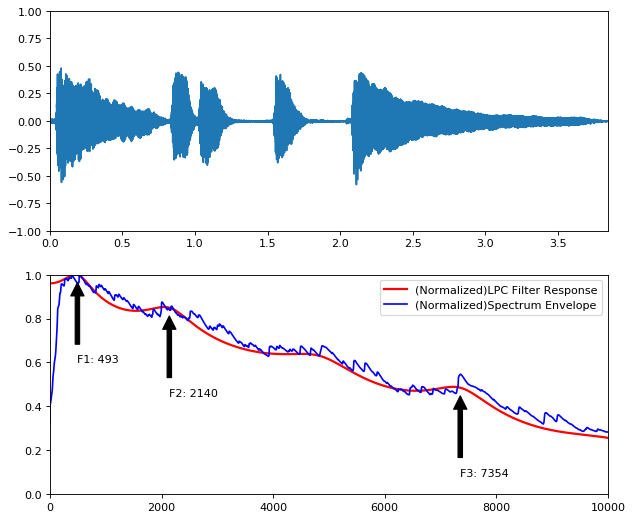

In [3]:
#Analysis (and plot) of another signal
x = ess.MonoLoader(filename="data/piano.wav", sampleRate=fs)() 
ff_p, fm_p = getFormantFrequencies(x,fs,LPCorder,nFreq, maxFreqToDisp)

In this example, the formant around 5000Hz is skipped beacuse next peak is due to a pole-pair closer to unit circle (its peak is sharper)

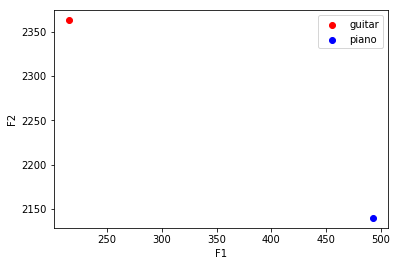

In [4]:
#Scatter plot of the two first formants of the two previous signals
plt.scatter(ff_g[0], ff_g[1], color='r' , label='guitar')
plt.scatter(ff_p[0], ff_p[1], color='b' , label='piano')
plt.xlabel('F1')
plt.ylabel('F2')
plt.legend(loc='best')

The first and the second formants can be plotted as shown to 'summarize' the spectral envelope of a signal.

This tool is largely used in speech processing to visualize  phonemes.

https://home.cc.umanitoba.ca/~krussll/phonetics/acoustic/formants.html
<img src='https://home.cc.umanitoba.ca/~krussll/phonetics/acoustic/img/f1f2-1.png'>

In the following, an analysis on Freesound signals is presented.

In [5]:
#tag and duration added to the getSoundFromFreesound() function
import sys,os
sys.path.append(os.path.join(os.path.dirname('__file__'), 'freesound-python/'))

import freesound

def getSoundFromFreesound(token, queryStrings, tag, duration): 
    client = freesound.FreesoundClient()
    #You are expected to place your token in the line below
    client.set_token(token,"token")

    maxNumFilePerInst=50 
    #14 sounds instead of 50 are retrieved. 
    #But, if we make a manual research on freesound, other sounds could be downloaded

    
    for queryStr in queryStrings:
        if duration and type(duration) == tuple:
            flt_dur = " duration:[" + str(duration[0])+ " TO " +str(duration[1]) + "]"
        else:
            flt_dur = ""

        if tag and type(tag) == str:
            flt_tag = "tag:"+tag
        else:
            flt_tag = ""
            
        results = client.text_search(query=queryStr,filter = flt_tag + flt_dur, fields="id,name,previews,tags")
        cnt=0
        for sound in results:
            #print(sound.name)
            sound.retrieve_preview(".",sound.name+".wav")
            os.rename(sound.name+".wav","data/"+queryStr+"_"+str(cnt)+".wav")
            cnt=cnt+1
            if cnt>=maxNumFilePerInst:
                break

    print("Files are copied! check your folder")

In [6]:
token="...putYourFreesoundTokenhere..."#refer to : DownloadDataFromDunya_noToken.ipynb for info
queryStrings=["piano","guitar"]
tag="loop"
dur=(0,5)#(start,stop)
getSoundFromFreesound(token, queryStrings, tag, dur)

Files are copied! check your folder


In [7]:
def initiateData4File(file,root):
    '''Forming the data structure for file
    Parameters
    ----------
    file,root : str
        File name and path info
    
    Returns
    -------
    fileData : dict
        Dictionary containing all info and data for the file
    ''' 
    fileData=dict();fileData['name']=file;fileData['path']=root;
    fileData['formantFreq']=[];fileData['formantMagn']=[]
    
    return fileData

In [8]:
#Setting analysis parameters
'''fs,LPCorder,nFreq,maxFreqToDisp=10000'''
params=AnalysisParams(44100,20,3)
soundsDir='data/'

#Gathering all wave files in a folder(including subfolders)
instFiles=dict()#dictionary containing for each instrument a list that carries dictionaries
for root, dirs, files in os.walk(soundsDir):
    for file in files:
        if file.endswith('.wav') and ('_' in file):
            instrument=file.split('_')[0]
            fileData=initiateData4File(file,root)            
            files4instrument=instFiles.get(instrument)
            if files4instrument==None:
                files4instrument=[fileData]
            else:
                files4instrument.append(fileData)
            instFiles[instrument]=files4instrument
#Feature extraction for all files of each instrument
for instrument, filesData in instFiles.items():
    for fileInd in range(len(filesData)):
        getFormantFrequenciesWrapper(instFiles[instrument][fileInd],params)
#Instruments & features list
instruments=list(instFiles.keys())

#Plotting samples on global feature space
featsData=dict()
featuresData=dict()
feature='formantFreq'
for instrument in instruments:
    featuresData=dict()
    for i in np.arange(2):
        data=[]
        for fileInd in range(len(instFiles[instrument])):
            data.append(instFiles[instrument][fileInd][feature][i])
        featuresData[feature+str(i+1)]=data 
    featsData[instrument]=featuresData

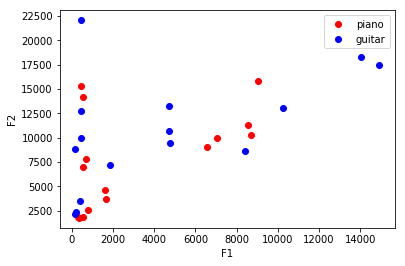

In [9]:
#Scatter plot of all the signals obtained from Freesound

colors=['r','k']

instrInd=0
style=('ro','bo')
i=0
for instr in instruments:
    plt.plot(featsData[instr]['formantFreq1'], featsData[instr]['formantFreq2'], style[i])
    i=i+1

    '''
    for fileInd in range(len(instFiles[instrument])):
        plt.scatter(instFiles[instr][fileInd]['formantFreq'][0], instFiles[instr][fileInd]['formantFreq'][1], color=colors[instrInd], label=instruments)
    instrInd=instrInd+1
    '''
plt.xlabel('F1')
plt.ylabel('F2')
plt.legend((instruments[0],instruments[1]), loc='best')

#Probably is better to order the formants by frequency and show only the two first formant by frequency sorting

By looking at the plot is it clear that, using the current implementation of formant tracking, is not possible to discern guitar from piano sounds. In some cases it seems that the formant extraction fails (some F2 are detected to be as high as >20kHz). One idea for improvement would be to detect many formants and then sort them with respect to frequency and choose the lowest two. 